In [2]:
#import library
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from utils.sample_points import uniform_sampling
# import sys
# sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
from utils.sample_points import uniform_sampling
from cityscapesscripts.helpers.labels import trainId2label as trainid2label

/home/ywh/anaconda3/envs/sam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [4]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_points2(coords, labels, ax, marker_size=25):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

In [ ]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [62]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [ ]:
def trainid2color(trainid):
    '''
    function: convert trainID to color in cityscapes
    input: trainid
    output: color
    '''
    #if the input is a number in np.uint8, it means it is a trainid
    if type(trainid) == np.uint8:
        label_object = trainid2label[trainid]
        return label_object.color[::-1]
    else:
        color_mask = np.zeros((trainid.shape[0], 3), dtype=np.uint8)
        for i in range(trainid.shape[0]):
            label_object = trainid2label[trainid[i]]
            color_mask[i] = label_object.color[::-1]
    return color_mask

In [ ]:
def color_segmentation(segmentation):
    #get the color segmentation result, initial the color segmentation result with black (0,0,0)
    #input: segmentation [h, w]
    color_segmentation = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)
    train_ids = np.unique(segmentation)
    for train_id in train_ids:
        color_segmentation[segmentation == train_id] = trainid2color(train_id)[::-1]
    return color_segmentation

In [1]:
thing_ids = range(19)
class_names = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
# thing_ids = [11, 12, 13, 14, 15, 16, 17, 18]

#load image
image = cv2.imread('images/aachen_000029_000019_leftImg8bit.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = cv2.imread('images/aachen_000029_000019_gtFine_labelTrainIds.png', cv2.IMREAD_GRAYSCALE)
color_label = color_segmentation(label)

#show image
plt.figure(figsize=(12,6))
plt.imshow(image)
plt.axis('on')
plt.show()
plt.close()

#show label
plt.figure(figsize=(12,6))  # constrained_layout=True
plt.imshow(color_label)
plt.axis('off')
# plt.tight_layout()
plt.show()
plt.close()

NameError: name 'cv2' is not defined

In [ ]:
#load model
sam_checkpoint = "models/sam_vit_h_4b8939.pth" #sam_vit_b_01ec64.pth, sam_vit_l_0b3195.pth
model_type = "vit_h" #vit_b, vit_h, vit_l

device = "cuda:0"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
print('load model successfully')

#set predictor
predictor = SamPredictor(sam)
#Process the image to produce an image embedding by calling `SamPredictor.set_image`. 
#`SamPredictor` remembers this embedding and will use it for subsequent mask prediction.
predictor.set_image(image) #get the image embedding, for subsequent mask prediction

#show the points on the image
# input_point = np.array([[500, 375]]) #input the point prompt in the format of (x, y)
# input_label = np.array([1]) #input the label prompt in the format of (0: background, 1: foreground)

# plt.figure(figsize=(10,10))
# plt.imshow(image)
# show_points(input_point, input_label, plt.gca())
# plt.axis('on')
# plt.show()  

# Predict with `SamPredictor.predict`. 
# The model returns masks, quality predictions for those masks, 
# and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
# point-level prompt
# input_point = np.array([[1024, 490], [1075, 482], [1001, 452]]) #车1
# input_point = np.array([[526, 471], [529, 427], [640, 488], [690, 471]]) #车2
# input_point = np.array([[1024, 490], [1075, 482], [1001, 452], [526, 471], [529, 427], [640, 488], [690, 471]]) #车3
# input_point = np.array([[363, 103], [392, 541], [385, 593]]) # vegetation1
# input_point = np.array([[988, 270], [918, 302], [1030, 324], [883, 342], [1134, 305], [1115, 253]]) #vegetation 2
# input_point = np.array([[363, 103], [392, 541], [385, 593], [988, 270], [918, 302], [1030, 324], [883, 342], [1134, 305], [1115, 253]])
# input_point = np.array([[668, 364], [670, 459], [668, 568]]) # pole
# input_point = np.array([[1651, 369], [1649, 465], [1652, 568]])
input_point = np.array([[668, 364], [670, 459], [668, 568], [1651, 369], [1649, 465], [1652, 568]])

input_label = np.array([1] * len(input_point))
# input_point = np.array([[1024, 490], [1075, 482], [1001, 452], [549, 463], [584, 432], [603, 501]])
# input_label = np.array([1, 1, 1, 1, 1, 1])

masks, scores, logits = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)

for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(16, 8))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
        plt.close()

# input_point2 = np.array([[1024, 490], [1075, 482], [1001, 452], [549, 463], [584, 432], [603, 501]])
# input_label2 = np.array([1, 1, 1, 1, 1, 1])

masks2, scores2, logits2 = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=False)
plt.figure(figsize=(16, 8))
plt.imshow(image)
show_mask(masks2, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask, Score: {scores2[0]:.3f}", fontsize=18)
plt.axis('off')
plt.show()
plt.close()


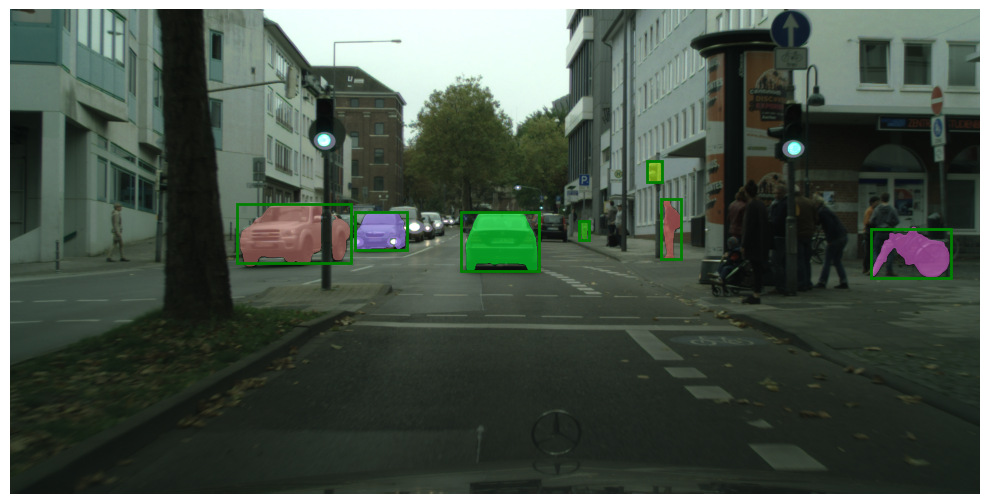

In [72]:
# box-level prompt
image1_boxes = torch.tensor([
    [952, 428, 1117, 553],
    [479, 412, 720, 535],
    [727, 428, 838, 509],
    [1374, 400, 1416, 528],
    [1344, 321, 1376, 364],
    # [1361, 301, 1375, 527],
    [1818, 464, 1987, 568],
    [1201, 447, 1221, 488],
], device=sam.device)

batched_input = [
     {
         'image': prepare_image(image, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image.shape[:2]),
         'original_size': image.shape[:2]  # 
     },
]

batched_output = sam(batched_input, multimask_output=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(image)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax, random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax)
ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
unique_ids = np.unique(label)
unique_ids = unique_ids[unique_ids != 255]
for unique_id in unique_ids:
    if unique_id not in thing_ids:
        continue
    print('class:', class_names[unique_id])
    
    #foreground points
    id_mask = label == unique_id
    sample_points = uniform_sampling(id_mask, 0.001, 10)
    input_point = np.array(sample_points)
    input_label = np.array([1] * len(sample_points))
    
    # #add background points
    # bg_mask = id_mask == False
    # sample_bg_points = uniform_sampling(bg_mask, 0.0001, 10)
    # background_point = np.array(sample_bg_points)
    # background_label = np.array([0] * len(sample_bg_points))
    
    # #concate the foreground points and background points
    # input_point = np.concatenate([input_point, background_point], axis=0)
    # input_label = np.concatenate([input_label, background_label], axis=0)
    

    # masks, scores, logits = predictor.predict(
    # point_coords=input_point,
    # point_labels=input_label,
    # multimask_output=True,
    # )

    # for i, (mask, score) in enumerate(zip(masks, scores)):
    #     plt.figure(figsize=(16, 8))
    #     plt.imshow(image)
    #     show_mask(mask, plt.gca())
    #     show_points2(input_point, input_label, plt.gca())
    #     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    #     plt.axis('off')
    #     plt.savefig('outputs_tmp/{}_{}.png'.format(class_names[unique_id], i), bbox_inches='tight', pad_inches=0)
    #     plt.show()
    # plt.close()
    
# input_point = np.array([[500, 375], [1125, 625]])
# input_label = np.array([1, 1])

    # mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    
    # masks, _, _ = predictor.predict(
    # point_coords=input_point,
    # point_labels=input_label,
    # mask_input=mask_input[None, :, :],
    # multimask_output=False,
    # )
    
    masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
    )

    plt.figure(figsize=(16, 8))
    plt.imshow(image)
    show_mask(masks, plt.gca())
    show_points2(input_point, input_label, plt.gca())
    plt.title(f"Class: {class_names[unique_id]}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.savefig('outputs_tmp/{}.png'.format(class_names[unique_id]), bbox_inches='tight', pad_inches=0)
    plt.show()

# input_point = np.array([[500, 375], [1125, 625]])
# input_label = np.array([1, 0])

# mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

# masks, _, _ = predictor.predict(
# point_coords=input_point,
# point_labels=input_label,
# mask_input=mask_input[None, :, :],
# multimask_output=False,
# )

# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# show_mask(masks, plt.gca())
# show_points(input_point, input_label, plt.gca())
# plt.axis('off')
# plt.show() 